- 尝试使用`lstm`对单特征的时间序列进行预测，原理如 Figure 1
    - 当向后预测的时间差很小的时候（比如1h），即对应图中 W(t) 预测 W(t+1)，效果很好，如1.1节末尾图。
    - 当尝试增大向后预测的时间间隔时（比如比赛中要求的48h），即对应图中 W(t) 预测 W(t+48)，模型的预测效果变得很差。
- 我理解这里边的原因
    - 当时间差很小的时候（比如1h），新一时刻的预测是基于之前所有的完整信息
    - 而当时间差很大时（比如48h），预测新一时刻的值只能止于两天之前的数据，这肯定是不能准确的
- 所以我的问题是
    - 这样的模型本身是不是不合理的，因为在预测 W(t+48) 时，只用到了 W(t) 及之前的信息，而没有用到 W(t+1)～W(t+47) 的信息
    - 是不是像 Figure 2 一样的 `attention model` 在原理上更合适一些，或者说这两种模型都不合适，应该用另外某种模型

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-14-lstm_predict_aq.png)
<caption><center> **Figure 1**: lstm model</center></caption>

<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
<caption><center> **Figure 1**: attention model</center></caption>

In [1]:
# Using pandas to process data
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

from data_util import parse_bj_aq_data, plot_station, plot_stations, generate_model_data, generate_data_for_lstm
from model import rnn_model

Using TensorFlow backend.


In [2]:
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'wanshouxigong_aq', 'yongledian_aq', 'tongzhou_aq', 'yongdingmennei_aq', 'mentougou_aq', 'yizhuang_aq', 'yanqin_aq', 'huairou_aq', 'nongzhanguan_aq', 'badaling_aq', 'shunyi_aq', 'yufa_aq', 'aotizhongxin_aq', 'beibuxinqu_aq', 'xizhimenbei_aq', 'pingchang_aq', 'zhiwuyuan_aq', 'fangshan_aq', 'daxing_aq', 'dongsi_aq', 'pinggu_aq', 'dingling_aq', 'wanliu_aq', 'liulihe_aq', 'qianmen_aq', 'gucheng_aq', 'miyun_aq', 'nansanhuan_aq', 'yungang_aq', 'dongsihuan_aq', 'tiantan_aq', 'miyunshuiku_aq', 'donggaocun_aq', 'guanyuan_aq', 'fengtaihuayuan_aq'}


/notebooks/KDD_Cup_2018/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/notebooks/KDD_Cup_2018/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


# 1. 单一特征

In [3]:
# take some data for example
ts = bj_aq_stations_merged["tongzhou_aq_PM2.5"]

## 1.1 向前预测一步时预测效果较好

In [4]:
num_periods = 30
f_horizon = 1

In [5]:
X_batches, y_batches, X_test, y_test = generate_data_for_lstm(ts, num_periods = num_periods, f_horizon = f_horizon)

length of training data x :  (10290,)
length of training data y :  (10290,)
training data x shape :  (343, 30, 1)


0   MSE: 5.56319e+07
100   MSE: 3.78486e+06
200   MSE: 2.7301e+06
300   MSE: 2.3287e+06
400   MSE: 2.23026e+06
500   MSE: 2.16787e+06
600   MSE: 2.11791e+06
700   MSE: 2.06538e+06
800   MSE: 2.05692e+06
900   MSE: 2.00544e+06
1000   MSE: 1.95634e+06
1100   MSE: 1.93421e+06
1200   MSE: 1.88717e+06
1300   MSE: 1.86941e+06
1400   MSE: 1.83396e+06
1500   MSE: 1.8069e+06
1600   MSE: 1.81405e+06
1700   MSE: 1.7816e+06
1800   MSE: 1.73864e+06
1900   MSE: 1.73133e+06
2000   MSE: 1.7288e+06
2100   MSE: 1.692e+06
2200   MSE: 1.68036e+06
2300   MSE: 1.67657e+06
2400   MSE: 1.68508e+06
2500   MSE: 1.62077e+06
2600   MSE: 1.61376e+06
2700   MSE: 1.59602e+06
2800   MSE: 1.61709e+06
2900   MSE: 1.57992e+06
3000   MSE: 1.58908e+06
3100   MSE: 1.57218e+06
3200   MSE: 1.56925e+06
3300   MSE: 1.54239e+06
3400   MSE: 1.51951e+06
3500   MSE: 1.53242e+06
3600   MSE: 1.50414e+06
3700   MSE: 1.63377e+06
3800   MSE: 1.5006e+06
3900   MSE: 1.52838e+06
4000   MSE: 1.49042e+06
4100   MSE: 1.47366e+06
4200   MSE: 

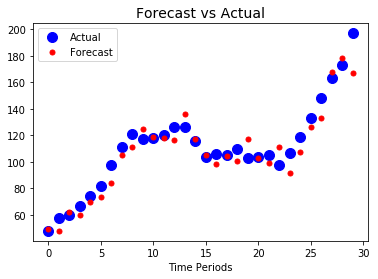

In [7]:
losses, Y_pred = rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
                  learning_rate=0.001, epochs=8000, print_every=100, 
                  inputs=1, outputs=1, hidden=100, num_periods=num_periods)

## 1.2 向前预测多步

In [11]:
def moving_f_horizons(ts, f_horizons, num_periods):
    '''
    Check the relationship between f_horizon, num_periods against the behavior.
    Parameters must match.
    
    Argus:
        ts : time series to be used.
        f_horizons : how many steps predicting.
        num_periods : total length of Tx.
    '''
    y_tests = []
    y_preds = []
    Losses = []
    for f_horizon in f_horizons:    
        X_batches, y_batches, X_test, y_test = generate_data_for_lstm(ts, num_periods = num_periods, f_horizon = f_horizon)
        print(X_test.shape)
        print("f_horizon is %d." %f_horizon)
        losses, y_pred = rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
                  learning_rate=0.001, epochs=2000, print_every=100, 
                  inputs=1, outputs=1, hidden=100, num_periods=num_periods)
        y_tests.append(y_test)
        y_preds.append(y_pred)
        Losses.append(losses)
        
    return Losses, y_tests, y_preds

length of training data x :  (10248,)
length of training data y :  (10248,)
training data x shape :  (61, 168, 1)
(1, 168, 1)
f_horizon is 2.
0   MSE: 6.78358e+07
100   MSE: 7.67478e+06
200   MSE: 6.95261e+06
300   MSE: 6.47464e+06
400   MSE: 6.13976e+06
500   MSE: 5.80404e+06
600   MSE: 5.51472e+06
700   MSE: 5.28588e+06
800   MSE: 5.13377e+06
900   MSE: 5.13208e+06
1000   MSE: 4.834e+06
1100   MSE: 4.87604e+06
1200   MSE: 4.68181e+06
1300   MSE: 4.68372e+06
1400   MSE: 4.489e+06
1500   MSE: 4.40548e+06
1600   MSE: 4.44685e+06
1700   MSE: 4.30618e+06
1800   MSE: 4.26051e+06
1900   MSE: 4.34155e+06
length of training data x :  (10248,)
length of training data y :  (10248,)
training data x shape :  (61, 168, 1)
(1, 168, 1)
f_horizon is 5.
0   MSE: 7.10774e+07
100   MSE: 1.95383e+07
200   MSE: 1.84385e+07
300   MSE: 1.77443e+07
400   MSE: 2.08167e+07
500   MSE: 1.87394e+07
600   MSE: 1.79169e+07
700   MSE: 1.72134e+07
800   MSE: 1.60035e+07
900   MSE: 1.48371e+07
1000   MSE: 1.61116e+07


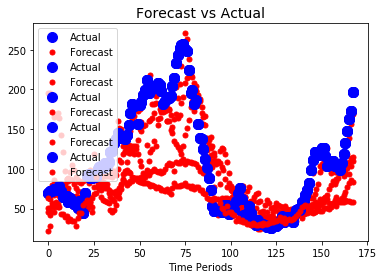

In [12]:
f_horizons = [2,5,10,20,48]
num_periods = 168

Losses, y_tests, y_preds = moving_f_horizons(ts, f_horizons, num_periods)

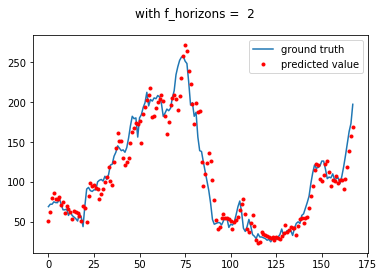

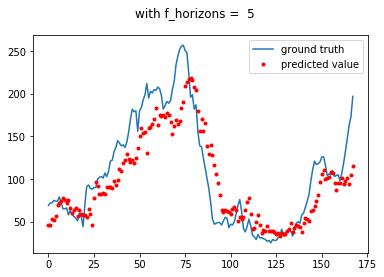

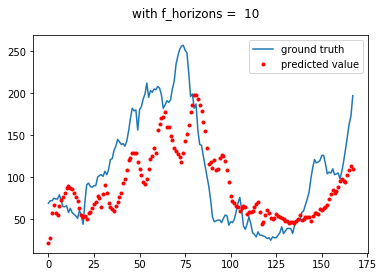

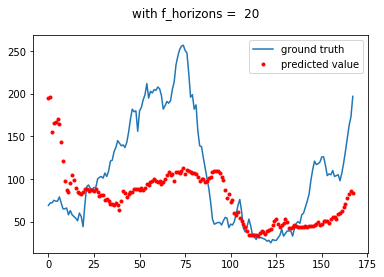

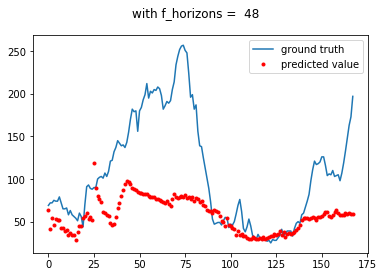

In [17]:
for i in range(len(Losses)):
    
    y_test = np.squeeze(y_tests[i])
    y_pred = np.squeeze(y_preds[i])
    
    fig, ax=plt.subplots(1, 1)
    
    x = range(len(y_test))
    
    f_horizon = f_horizons[i]
    fig.suptitle('with f_horizons =  %i' %(f_horizon));
      
    # p = plt.subplot(num)
    ax.plot(x, y_test, label="ground truth")
    ax.plot(x, y_pred, 'r.', label="predicted value")
    ax.legend()

In [18]:
# 2 featurs
# ts = bj_aq_stations_merged["tongzhou_aq_PM2.5", "tongzhou_aq_PM10"]